In [2]:
import pandas as pd
import numpy as np
import math
import os
o = pd.DataFrame()
for jointype in ["ajoin", "join"]:
    for engine in ["new", "old"]:
        for size in ["2m","2.5m","3m"]:
            for run in ["1","2","3"]:
                path ="./"+jointype+"/"+engine+"/"+size+"/run"+run+"/"
                files = os.listdir(path)
                s1 = pd.read_csv(next(path+f for f in files if "socket1" in f)).set_index("seconds")
                s2 = pd.read_csv(next(path+f for f in files if "socket2" in f)).set_index("seconds")
                util = pd.read_csv(next(path+f for f in files if "util" in f))
                lat = pd.read_csv(next(path+f for f in files if "sink" in f))
                lat["seconds"] = np.floor(np.array(lat.index/(lat.shape[0]/util.shape[0]))).astype(int)
                j = s1.merge(s2, on="seconds", suffixes=("_1", "_2")).join(util).merge(lat, on="seconds", how="right")
                j["events_1"] = np.array(j["events_1"]).astype(int)
                j["events_2"] = np.array(j["events_2"]).astype(int)
                j["run"]=run
                j["type"]=jointype
                j["engine"]=engine
                j["size"]=size
                j["memory_usage"] = j[" memory_usage"]
                j["seconds"] = np.array(lat.index/(lat.shape[0]/util.shape[0]))
                del j[" memory_usage"]
                if "ejectionTime" in j.columns:
                    j["processingTime"] = j["ejectionTime"]
                    del j["ejectionTime"]
                o = pd.concat([o, j])

In [3]:
o.head()

,seconds,events_1,events_2,cpu_usage,eventTime,processingTime,run,type,engine,size,memory_usage
0,0.000000,1987913,1987835,0.0,1594743321695,1594743322652,1,ajoin,new,2m,0.00
1,0.258340,1987913,1987835,0.0,1594743322558,1594743324023,1,ajoin,new,2m,0.00
2,0.516681,1987913,1987835,0.0,1594743322558,1594743324029,1,ajoin,new,2m,0.00
3,0.775021,1987913,1987835,0.0,1594743322637,1594743324034,1,ajoin,new,2m,0.00
4,1.033362,2000000,2000000,369.2,1594743322887,1594743324037,1,ajoin,new,2m,1.51


In [4]:
o.to_csv("benchmark.csv")

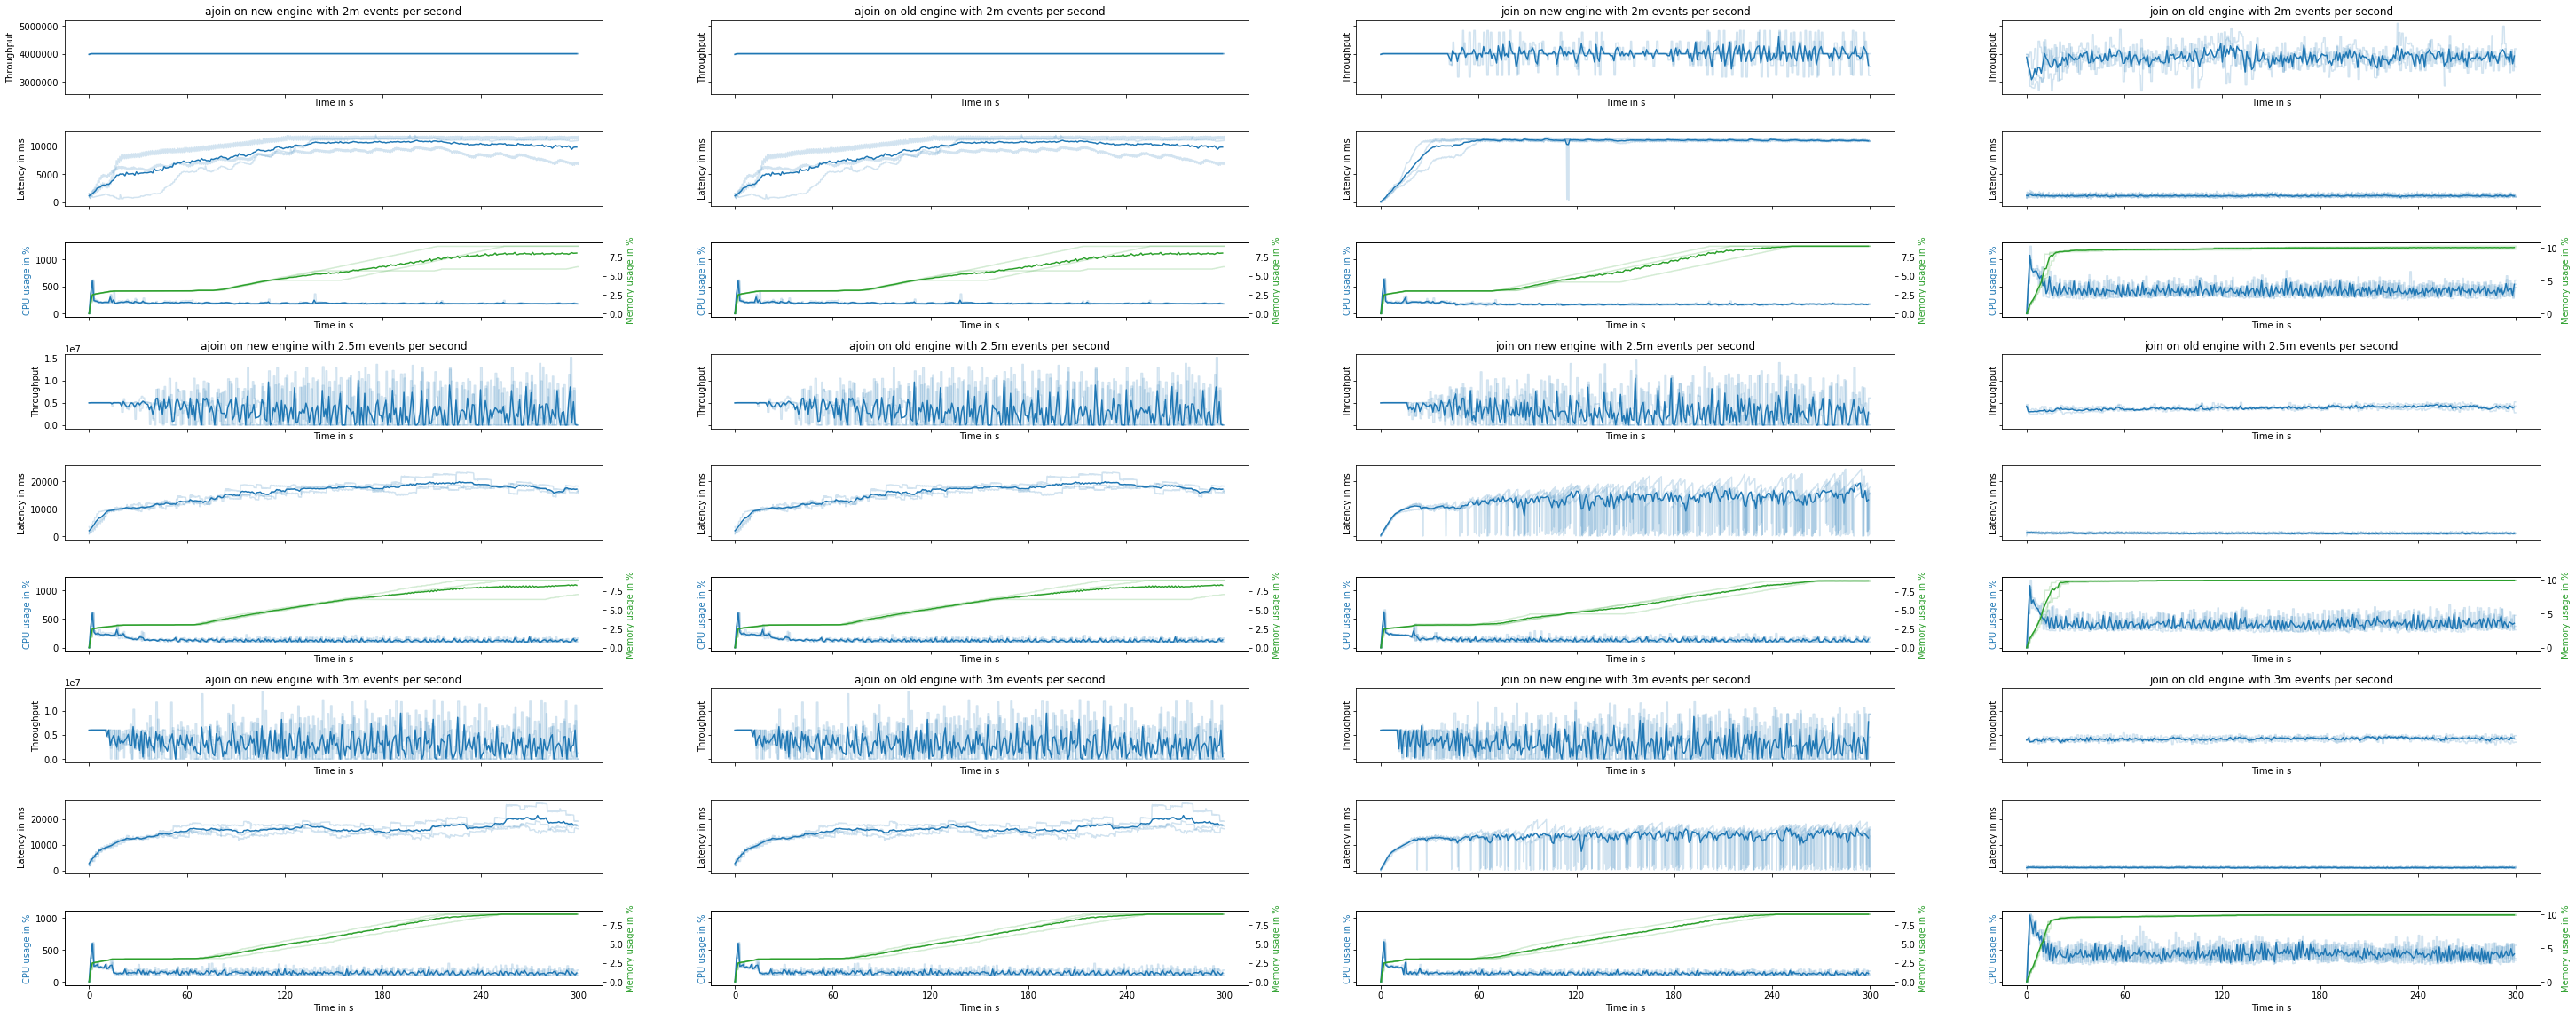

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(9,4, True, "row", figsize=(50,20), subplot_kw={"xticks": [0,60,120,180,240,300]}, gridspec_kw={"hspace": 0.5})
i=0
j=0
for jointype in ["ajoin", "join"]:
    for engine in ["new", "old"]:
        for size in ["2m","2.5m","3m"]:
            s = o.copy().query("type == '"+jointype+"' & engine == '"+engine+"' & size == '"+size+"' & seconds < 300")
            r1 = s.query("run == '1'")
            r2 = s.query("run == '2'")
            r3 = s.query("run == '3'")
            s["seconds"] = np.floor(np.array(s["seconds"])).astype(int)
            average = s.groupby(["seconds"]).mean()
            ax1 = ax[i][j]
            i+=1
            ax1.set_xlabel("Time in s")
            ax1.plot(r1["seconds"].to_numpy(), r1["events_1"].to_numpy()+r1["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(r2["seconds"].to_numpy(), r2["events_1"].to_numpy()+r2["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(r3["seconds"].to_numpy(), r3["events_1"].to_numpy()+r3["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(average.index.to_numpy(), average["events_1"].to_numpy()+average["events_2"].to_numpy(), color="tab:blue")
            ax1.set_ylabel("Throughput")
            ax1.tick_params(axis="both", which="major")
            ax1.set_xticklabels([0,60,120,180,240,300])
            ax2 = ax[i][j]
            i+=1
            ax2.plot(r1["seconds"].to_numpy(), r1["processingTime"].to_numpy()-r1["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(r2["seconds"].to_numpy(), r2["processingTime"].to_numpy()-r2["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(r3["seconds"].to_numpy(), r3["processingTime"].to_numpy()-r3["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(average.index.to_numpy(), average["processingTime"].to_numpy()-average["eventTime"].to_numpy(), color="tab:blue")
            ax2.set_ylabel("Latency in ms")
            ax2.tick_params(axis="both", which="major")
            ax2.set_xticklabels([0,60,120,180,240,300])
            ax3 = ax[i][j]
            i+=1
            ax3.set_xlabel("Time in s")
            ax3.plot(r1["seconds"].to_numpy(), r1["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(r2["seconds"].to_numpy(), r2["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(r3["seconds"].to_numpy(), r3["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(average.index.to_numpy(), average["cpu_usage"].to_numpy(), color="tab:blue")
            ax3.set_ylabel("CPU usage in %", color="tab:blue")
            ax3.tick_params(axis="both", which="major")
            ax3.set_xticklabels([0,60,120,180,240,300])
            ax4 = ax3.twinx()
            ax4.plot(r1["seconds"].to_numpy(), r1["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(r2["seconds"].to_numpy(), r2["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(r3["seconds"].to_numpy(), r3["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(average.index.to_numpy(), average["memory_usage"].to_numpy(), color="tab:green")
            ax4.set_ylabel("Memory usage in %", color="tab:green")
            ax1.set_title(jointype + " on "+engine+" engine with "+size+" events per second")
            if i == 9:
                j+=1
                i=0
plt.show()
fig.savefig("plots.svg")

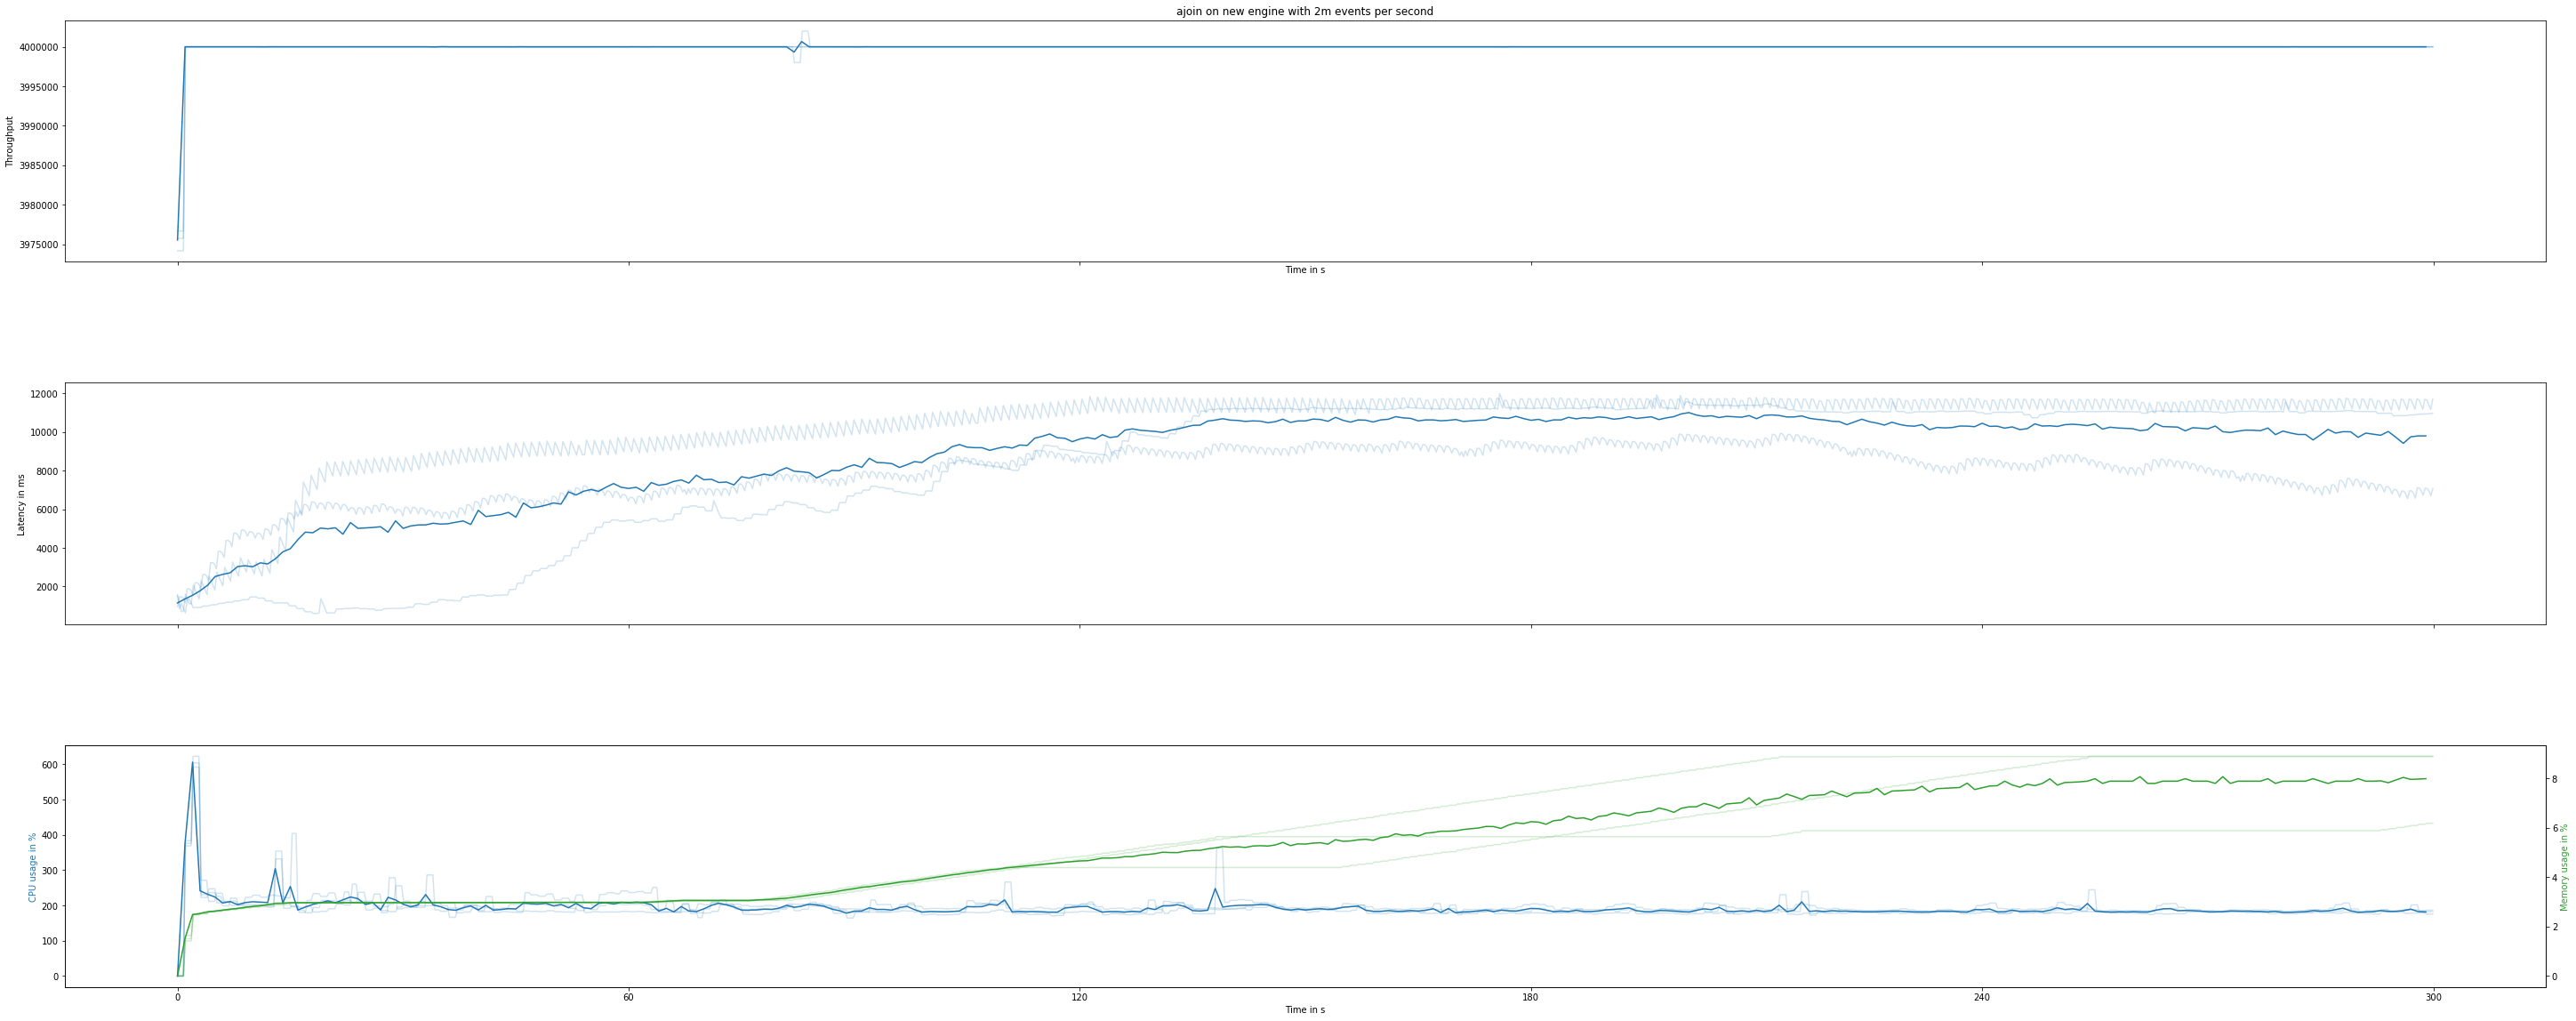

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, True, "row", figsize=(50,20), subplot_kw={"xticks": [0,60,120,180,240,300]}, gridspec_kw={"hspace": 0.5})
for jointype in ["ajoin", "join"]:
    for engine in ["new", "old"]:
        for size in ["2m","2.5m","3m"]:
            s = o.copy().query("type == '"+jointype+"' & engine == '"+engine+"' & size == '"+size+"' & seconds < 300")
            r1 = s.query("run == '1'")
            r2 = s.query("run == '2'")
            r3 = s.query("run == '3'")
            s["seconds"] = np.floor(np.array(s["seconds"])).astype(int)
            average = s.groupby(["seconds"]).mean()
            ax1 = ax[0]
            ax1.set_xlabel("Time in s")
            ax1.plot(r1["seconds"].to_numpy(), r1["events_1"].to_numpy()+r1["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(r2["seconds"].to_numpy(), r2["events_1"].to_numpy()+r2["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(r3["seconds"].to_numpy(), r3["events_1"].to_numpy()+r3["events_2"].to_numpy(), color="tab:blue", alpha=0.2)
            ax1.plot(average.index.to_numpy(), average["events_1"].to_numpy()+average["events_2"].to_numpy(), color="tab:blue")
            ax1.set_ylabel("Throughput")
            ax1.tick_params(axis="both", which="major")
            ax1.set_xticklabels([0,60,120,180,240,300])
            ax2 = ax[1]
            ax2.plot(r1["seconds"].to_numpy(), r1["processingTime"].to_numpy()-r1["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(r2["seconds"].to_numpy(), r2["processingTime"].to_numpy()-r2["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(r3["seconds"].to_numpy(), r3["processingTime"].to_numpy()-r3["eventTime"].to_numpy(), color="tab:blue", alpha=0.2)
            ax2.plot(average.index.to_numpy(), average["processingTime"].to_numpy()-average["eventTime"].to_numpy(), color="tab:blue")
            ax2.set_ylabel("Latency in ms")
            ax2.tick_params(axis="both", which="major")
            ax2.set_xticklabels([0,60,120,180,240,300])
            ax3 = ax[2]
            ax3.set_xlabel("Time in s")
            ax3.plot(r1["seconds"].to_numpy(), r1["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(r2["seconds"].to_numpy(), r2["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(r3["seconds"].to_numpy(), r3["cpu_usage"].to_numpy(), color="tab:blue", alpha=0.2)
            ax3.plot(average.index.to_numpy(), average["cpu_usage"].to_numpy(), color="tab:blue")
            ax3.set_ylabel("CPU usage in %", color="tab:blue")
            ax3.tick_params(axis="both", which="major")
            ax3.set_xticklabels([0,60,120,180,240,300])
            ax4 = ax3.twinx()
            ax4.plot(r1["seconds"].to_numpy(), r1["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(r2["seconds"].to_numpy(), r2["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(r3["seconds"].to_numpy(), r3["memory_usage"].to_numpy(), color="tab:green", alpha=0.2)
            ax4.plot(average.index.to_numpy(), average["memory_usage"].to_numpy(), color="tab:green")
            ax4.set_ylabel("Memory usage in %", color="tab:green")
            ax1.set_title(jointype + " on "+engine+" engine with "+size+" events per second")
            ax1.set_title(jointype + " on "+engine+" engine with "+size+" events per second")
            plt.show()
            fig.savefig(jointype+"_"+engine+"_"+size+".svg")